# _Support Vector Machine (SVM)_

The Web has long become a major platform for online criminal activities. URLs are used as the main vehicle in this domain. To counter this issues security community focused its efforts on developing techniques for mostly blacklisting of malicious URLs.

While successful in protecting users from known malicious domains, this approach only solves part of the problem. The new malicious URLs that sprang up all over the web in masses commonly get a head start in this race. Besides that, Alexa ranked, trusted websites may convey compromised fraudulent URLs called defacement URL.

We study mainly five different types of URLs:

**Benign URLs**: Over 35,300 benign URLs were collected from Alexa top websites. The domains have been passed through a Heritrix web crawler to extract the URLs. Around half a million unique URLs are crawled initially and then passed to remove duplicate and domain only URLs. Later the extracted URLs have been checked through Virustotal to filter the benign URLs.

**Spam URLs**: Around 12,000 spam URLs were collected from the publicly available WEBSPAM-UK2007 dataset.

**Phishing URLs**: Around 10,000 phishing URLs were taken from OpenPhish which is a repository of active phishing sites.

**Malware URLs**: More than 11,500 URLs related to malware websites were obtained from DNS-BH which is a project that maintain list of malware sites.

**Defacement URLs**: More than 45,450 URLs belong to Defacement URL category. They are Alexa ranked trusted websites hosting fraudulent or hidden URL that contains both malicious web pages.

#### Source https://www.unb.ca/cic/datasets/url-2016.html
_Mohammad Saiful Islam Mamun, Mohammad Ahmad Rathore, Arash Habibi Lashkari, Natalia Stakhanova and Ali A. Ghorbani, "Detecting Malicious URLs Using Lexical Analysis", Network and System Security, Springer International Publishing, P467--482, 2016._

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
import numpy as np
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.svm import SVC
from sklearn.datasets import make_moons
from sklearn.svm import LinearSVC
from sklearn.preprocessing import PolynomialFeatures

In [2]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, message='.*X does not have valid feature names.*')
warnings.filterwarnings('ignore', category=RuntimeWarning, message='.*invalid value encountered in subtract.*')

In [3]:
def splitData(df, testSize=0.2, valSize=0.2, randomState=42):
    trainValDf, testDf = train_test_split(df, test_size=testSize, random_state=randomState)
    trainDf, valDf = train_test_split(trainValDf, test_size=valSize, random_state=randomState)
    
    xTrain = trainDf.drop("URL_Type_obf_Type", axis=1)
    yTrain = trainDf["URL_Type_obf_Type"]
    xVal = valDf.drop("URL_Type_obf_Type", axis=1)
    yVal = valDf["URL_Type_obf_Type"]
    xTest = testDf.drop("URL_Type_obf_Type", axis=1)
    yTest = testDf["URL_Type_obf_Type"]
    
    return xTrain, xVal, xTest, yTrain, yVal, yTest

In [4]:
def plotSvcDecisionBoundary(svmClf, xMin, xMax):
    w = svmClf.coef_[0]
    b = svmClf.intercept_[0]
    x0 = np.linspace(xMin, xMax, 200)
    decisionBoundary = -w[0] / w[1] * x0 - b / w[1]

    margin = 1 / w[1]
    gutterUp = decisionBoundary + margin
    gutterDown = decisionBoundary - margin

    supportVectors = svmClf.support_vectors_
    plt.scatter(supportVectors[:, 0], supportVectors[:, 1], s=180, facecolors='#FFAAAA')

    plt.plot(x0, decisionBoundary, "k-", linewidth=2)
    plt.plot(x0, gutterUp, "k--", linewidth=2)
    plt.plot(x0, gutterDown, "k--", linewidth=2)

In [5]:
df = pd.read_csv("./data/Phishing.csv")

In [7]:
df.head()

,Querylength,domain_token_count,path_token_count,avgdomaintokenlen,longdomaintokenlen,avgpathtokenlen,tld,charcompvowels,charcompace,ldl_url,...,SymbolCount_FileName,SymbolCount_Extension,SymbolCount_Afterpath,Entropy_URL,Entropy_Domain,Entropy_DirectoryName,Entropy_Filename,Entropy_Extension,Entropy_Afterpath,URL_Type_obf_Type
0,0,2,12,5.5,8,4.083334,2,15,7,0,...,-1,-1,-1,0.676804,0.860529,-1.000000,-1.000000,-1.00000,-1.000000,benign
1,0,3,12,5.0,10,3.583333,3,12,8,2,...,1,0,-1,0.715629,0.776796,0.693127,0.738315,1.00000,-1.000000,benign
2,2,2,11,4.0,5,4.750000,2,16,11,0,...,2,0,1,0.677701,1.000000,0.677704,0.916667,0.00000,0.898227,benign
3,0,2,7,4.5,7,5.714286,2,15,10,0,...,0,0,-1,0.696067,0.879588,0.818007,0.753585,0.00000,-1.000000,benign
4,19,2,10,6.0,9,2.250000,2,9,5,0,...,5,4,3,0.747202,0.833700,0.655459,0.829535,0.83615,0.823008,benign


In [8]:
df.describe()

,Querylength,domain_token_count,path_token_count,avgdomaintokenlen,longdomaintokenlen,avgpathtokenlen,tld,charcompvowels,charcompace,ldl_url,...,SymbolCount_Directoryname,SymbolCount_FileName,SymbolCount_Extension,SymbolCount_Afterpath,Entropy_URL,Entropy_Domain,Entropy_DirectoryName,Entropy_Filename,Entropy_Extension,Entropy_Afterpath
count,15367.000000,15367.000000,15367.000000,15367.000000,15367.000000,15096.000000,15367.000000,15367.000000,15367.000000,15367.000000,...,15367.000000,15367.000000,15367.000000,15367.000000,15367.000000,15367.000000,13541.000000,15177.000000,15364.000000,15364.000000
mean,3.446021,2.543698,8.477061,5.851956,10.027461,5.289936,2.543698,12.659986,8.398516,1.910913,...,2.120843,1.124618,0.500813,-0.158782,0.721684,0.854232,0.634859,0.682896,0.313617,-0.723793
std,14.151453,0.944938,4.660250,2.064581,5.281090,3.535097,0.944938,8.562206,6.329007,4.657731,...,2.777307,2.570246,2.261013,2.535939,0.049246,0.072641,0.510992,0.502288,0.576910,0.649785
min,0.000000,2.000000,0.000000,1.500000,2.000000,0.000000,2.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,0.419560,0.561913,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.000000,2.000000,5.000000,4.500000,7.000000,3.800000,2.000000,6.000000,4.000000,0.000000,...,1.000000,0.000000,0.000000,-1.000000,0.687215,0.798231,0.709532,0.707165,0.000000,-1.000000
50%,0.000000,2.000000,8.000000,5.500000,9.000000,4.500000,2.000000,11.000000,7.000000,0.000000,...,2.000000,0.000000,0.000000,-1.000000,0.723217,0.859793,0.785949,0.814038,0.000000,-1.000000
75%,0.000000,3.000000,11.000000,6.666666,12.000000,5.571429,3.000000,17.000000,11.000000,1.000000,...,3.000000,1.000000,0.000000,-1.000000,0.757949,0.916667,0.859582,0.916667,1.000000,-1.000000
max,173.000000,19.000000,68.000000,29.500000,63.000000,105.000000,19.000000,94.000000,62.000000,58.000000,...,24.000000,31.000000,30.000000,29.000000,0.869701,1.000000,0.962479,1.000000,1.000000,1.000000


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15367 entries, 0 to 15366
Data columns (total 80 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Querylength                      15367 non-null  int64  
 1   domain_token_count               15367 non-null  int64  
 2   path_token_count                 15367 non-null  int64  
 3   avgdomaintokenlen                15367 non-null  float64
 4   longdomaintokenlen               15367 non-null  int64  
 5   avgpathtokenlen                  15096 non-null  float64
 6   tld                              15367 non-null  int64  
 7   charcompvowels                   15367 non-null  int64  
 8   charcompace                      15367 non-null  int64  
 9   ldl_url                          15367 non-null  int64  
 10  ldl_domain                       15367 non-null  int64  
 11  ldl_path                         15367 non-null  int64  
 12  ldl_filename      

In [10]:
phishing_count = df[df["URL_Type_obf_Type"] == "phishing"].shape[0]
benign_count = df[df["URL_Type_obf_Type"] == "benign"].shape[0]

print(f"Number of phishing URLs: {phishing_count}")
print(f"Number of benign URLs: {benign_count}")

Number of phishing URLs: 7586
Number of benign URLs: 7781


In [11]:
null_values = df.isnull().sum()
print(null_values[null_values > 0])

avgpathtokenlen              271
NumberRate_DirectoryName       9
NumberRate_FileName            9
NumberRate_Extension        7355
NumberRate_AfterPath           3
Entropy_DirectoryName       1826
Entropy_Filename             190
Entropy_Extension              3
Entropy_Afterpath              3
dtype: int64


In [12]:
infinite_values = df[df.isin([np.inf, -np.inf]).any(axis=1)]
print(infinite_values)

       Querylength  domain_token_count  path_token_count  avgdomaintokenlen  \
8541             0                   8                 1          12.875000   
11826            0                   9                 1           4.777778   
13162            0                   3                 1          12.333333   
13387            0                   4                 1           8.500000   
13793            0                   3                 1          10.666667   
14977            0                   4                 1           7.500000   
15124            0                   4                 1           7.250000   
15302            0                   3                 1           9.666667   
15353            0                   3                 1           9.333333   

       longdomaintokenlen  avgpathtokenlen  tld  charcompvowels  charcompace  \
8541                   60              0.0    8               0            0   
11826                   8              0.0    9  

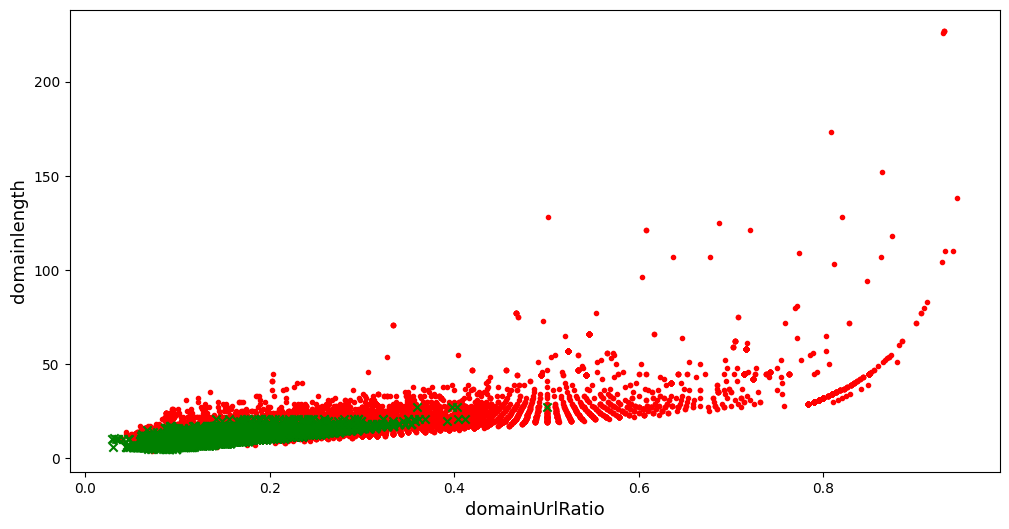

In [13]:
plt.figure(figsize=(12, 6))
plt.scatter(df["domainUrlRatio"][df['URL_Type_obf_Type'] == "phishing"], df["domainlength"][df['URL_Type_obf_Type'] == "phishing"], c="r", marker=".")
plt.scatter(df["domainUrlRatio"][df['URL_Type_obf_Type'] == "benign"], df["domainlength"][df['URL_Type_obf_Type'] == "benign"], c="g", marker="x")
plt.xlabel("domainUrlRatio", fontsize=13)
plt.ylabel("domainlength", fontsize=13)
plt.show()

In [14]:
X_train, X_val, X_test, y_train, y_val, y_test = splitData(df)

In [15]:
if "URL_Type_obf_Type" in X_train.columns:
    X_train = X_train.drop("URL_Type_obf_Type", axis=1)
y_train = df.loc[X_train.index, "URL_Type_obf_Type"]

if "URL_Type_obf_Type" in X_val.columns:
    X_val = X_val.drop("URL_Type_obf_Type", axis=1)
y_val = df.loc[X_val.index, "URL_Type_obf_Type"]

if "URL_Type_obf_Type" in X_test.columns:
    X_test = X_test.drop("URL_Type_obf_Type", axis=1)
y_test = df.loc[X_test.index, "URL_Type_obf_Type"]

In [16]:
df = df.replace([np.inf, -np.inf], np.nan).dropna(axis=1, how='any')

X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_val.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

In [17]:
imputer = SimpleImputer(strategy="median")

X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

In [18]:
scaler = RobustScaler()

X_train_prep = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val_prep = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test_prep = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [19]:
X_test_prep_df = pd.DataFrame(X_test_prep, columns=X_test.columns)

In [20]:
X_train_prep.head(10)

,Querylength,domain_token_count,path_token_count,avgdomaintokenlen,longdomaintokenlen,avgpathtokenlen,tld,charcompvowels,charcompace,ldl_url,...,SymbolCount_Directoryname,SymbolCount_FileName,SymbolCount_Extension,SymbolCount_Afterpath,Entropy_URL,Entropy_Domain,Entropy_DirectoryName,Entropy_Filename,Entropy_Extension,Entropy_Afterpath
0,30.0,1.0,0.000000,-0.384615,-0.4,4.213756,1.0,0.454545,0.857143,11.0,...,-0.5,4.0,4.0,4.0,0.166123,-0.399317,1.258396,-0.157980,0.833522,1.829107
1,0.0,0.0,0.500000,-0.923077,-1.0,0.237767,0.0,1.000000,1.142857,0.0,...,-0.5,-1.0,0.0,0.0,-1.096805,0.480204,1.068129,-0.880945,0.000000,0.000000
2,0.0,1.0,-0.333333,0.846154,1.6,-0.871812,1.0,-0.454545,-0.428571,0.0,...,0.0,1.0,1.0,0.0,0.112080,-0.524567,-1.347652,0.361593,1.000000,0.000000
3,0.0,1.0,-0.166667,1.000000,0.6,5.438443,1.0,0.090909,1.571429,18.0,...,0.5,-1.0,0.0,0.0,-0.835361,-0.235076,-0.658292,-0.356908,0.000000,0.000000
4,0.0,0.0,-0.166667,1.153846,0.8,-0.041515,0.0,0.181818,0.285714,0.0,...,0.5,-1.0,0.0,0.0,-0.271522,0.211735,-0.107484,0.146540,0.000000,0.000000
5,138.0,0.0,0.833333,0.230769,0.0,1.670972,0.0,2.181818,5.428571,33.0,...,1.0,4.0,4.0,4.0,-1.679121,0.481750,-0.148618,-0.927902,0.616231,1.608315
6,0.0,0.0,0.000000,0.461538,0.2,0.363255,0.0,0.272727,-0.142857,0.0,...,0.5,-1.0,0.0,0.0,0.157265,0.233397,-0.245691,0.413793,0.000000,0.000000
7,0.0,1.0,-0.666667,0.076923,0.6,-0.145302,1.0,-0.454545,-0.428571,1.0,...,-0.5,0.0,0.0,0.0,0.813313,0.137688,0.763086,0.906125,1.000000,0.000000
8,0.0,0.0,1.833333,-1.384615,-1.2,-0.290604,0.0,1.636364,2.142857,0.0,...,0.5,-1.0,0.0,0.0,-0.760830,1.183821,0.020106,-0.633907,0.000000,0.000000
9,0.0,0.0,-0.666667,0.230769,0.0,-0.145302,0.0,-0.727273,-0.571429,3.0,...,-0.5,0.0,0.0,0.0,0.559789,0.481750,0.692836,0.293082,1.000000,0.000000


In [21]:
null_values_train = X_train.isnull().sum() 
print(null_values_train[null_values_train > 0])

Series([], dtype: int64)


## SVM: lineal kernel

In [22]:
X_train_reduced = X_train_prep[["domainUrlRatio", "domainlength"]].copy()
X_val_reduced = X_val_prep[["domainUrlRatio", "domainlength"]].copy()

In [23]:
X_train_reduced

,domainUrlRatio,domainlength
0,-0.369107,0.285714
1,-0.569208,-0.857143
2,1.306154,1.428571
3,-0.112823,1.571429
4,0.379206,0.428571
...,...,...
9829,1.733508,6.142857
9830,0.247482,-0.285714
9831,0.267798,0.428571
9832,0.010760,0.714286


In [24]:
svm_clf = SVC(kernel="linear", C=50)
svm_clf.fit(X_train_reduced, y_train)

SVC(C=50, kernel='linear')

In [25]:
def plotSvcDecisionBoundary(svmClf, xMin, xMax):
    w = svmClf.coef_[0]
    b = svmClf.intercept_[0]

    x0 = np.linspace(xMin, xMax, 200)
    decisionBoundary = -w[0] / w[1] * x0 - b / w[1]
    margin = 1 / w[1]
    gutterUp = decisionBoundary + margin
    gutterDown = decisionBoundary - margin

    supportVectors = svmClf.support_vectors_
    plt.scatter(supportVectors[:, 0], supportVectors[:, 1], s=180, facecolors='#FFAAAA')

    plt.plot(x0, decisionBoundary, "k-", linewidth=2)
    plt.plot(x0, gutterUp, "k--", linewidth=2)
    plt.plot(x0, gutterDown, "k--", linewidth=2)

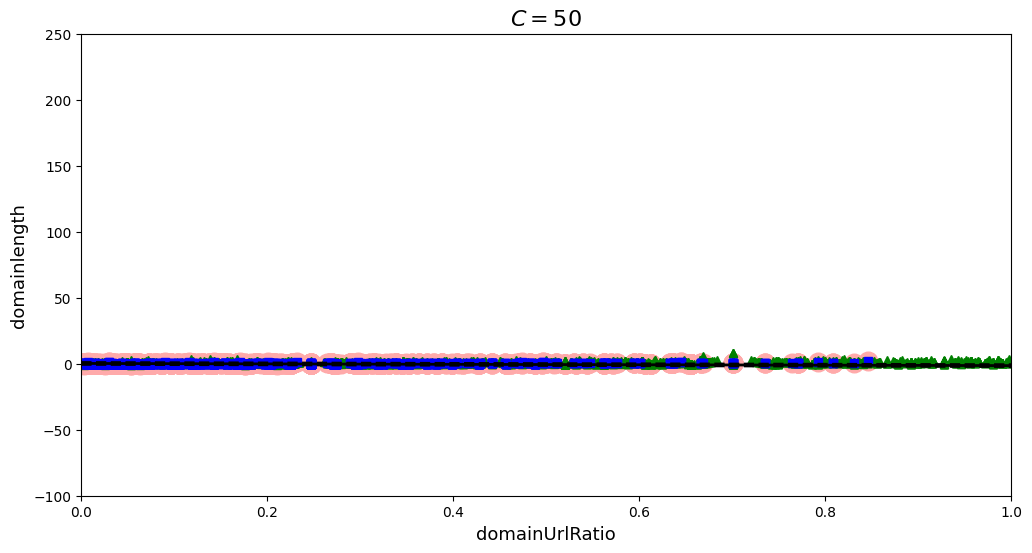

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(X_train_reduced.values[:, 0][y_train=="phishing"], X_train_reduced.values[:, 1][y_train=="phishing"], "g^")
plt.plot(X_train_reduced.values[:, 0][y_train=="benign"], X_train_reduced.values[:, 1][y_train=="benign"], "bs")
plotSvcDecisionBoundary(svm_clf, 0, 1)
plt.title("$C = {}$".format(svm_clf.C), fontsize=16)
plt.axis([0, 1, -100, 250])
plt.xlabel("domainUrlRatio", fontsize=13)
plt.ylabel("domainlength", fontsize=13)
plt.show()

In [27]:
y_val_pred = svm_clf.predict(X_val_reduced)

In [29]:
f1Score = f1_score(y_val, y_val_pred, average='weighted')
print(f"{f1Score}")

0.8290344040254889


In [30]:
svm_clf_sc = Pipeline([("scaler", RobustScaler()), ("linear_svc", SVC(kernel="linear", C=50)),])
svm_clf_sc.fit(X_train_reduced, y_train)

Pipeline(steps=[('scaler', RobustScaler()),
                ('linear_svc', SVC(C=50, kernel='linear'))])

In [31]:
y_val_pred = svm_clf_sc.predict(X_val_reduced)

In [33]:
svm_clf_full = SVC(kernel="linear", C=1)
svm_clf_full.fit(X_train_prep, y_train)
y_val_pred_full = svm_clf_full.predict(X_val_prep)

In [34]:
f1Score_full = f1_score(y_val, y_val_pred_full, average='weighted')
print(f"{f1Score_full}")

0.9629896556756443


In [36]:
svm_clf_full = SVC(kernel="linear", C=1)
svm_clf_full.fit(X_train_prep, y_train)

y_val_pred = svm_clf_full.predict(X_val_prep)
y_test_pred = svm_clf_full.predict(X_test_prep)

In [37]:
f1Score_test = f1_score(y_test, y_test_pred, average='weighted')
print(f"{f1Score_test}")

0.959661285773224


## SVM: no lineal kernel

### Polynomial

In [38]:
y_train_num = y_train.factorize()[0]
y_val_num = y_val.factorize()[0]

In [39]:
polynomial_svm_clf = Pipeline([
    ("poly_features", PolynomialFeatures(degree=3)), 
    ("scaler", StandardScaler()),
    ("svm_clf", LinearSVC(C=20, loss="hinge", random_state=42, max_iter=100000, dual=True))
])

polynomial_svm_clf.fit(X_train_reduced, y_train_num)

Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('scaler', StandardScaler()),
                ('svm_clf',
                 LinearSVC(C=20, dual=True, loss='hinge', max_iter=100000,
                           random_state=42))])

In [40]:
def plotDataset(X, y):
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g.")
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "b.")

def plotPredictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

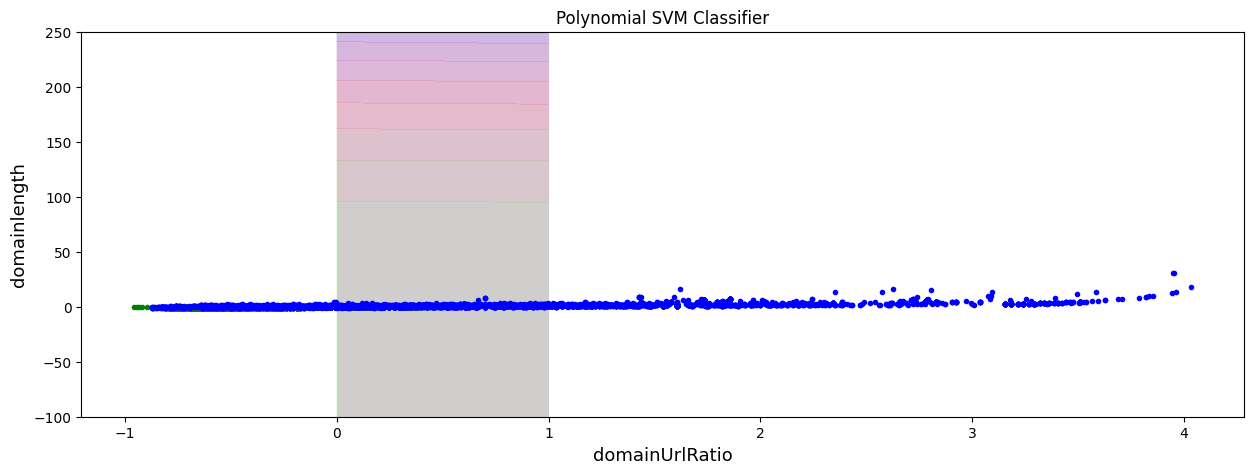

In [51]:
fig, axes = plt.subplots(figsize=(15,5), sharey=True)
plotDataset(X_train_reduced.values, y_train_num)
plotPredictions(polynomial_svm_clf, [0, 1, -100, 250])
plt.title("Polynomial SVM Classifier")
plt.xlabel("domainUrlRatio", fontsize=13)
plt.ylabel("domainlength", fontsize=13)
plt.show()

In [53]:
y_val_pred = polynomial_svm_clf.predict(X_val_reduced)
y_test_pred = svm_clf_full.predict(X_test_prep)

In [54]:
f1_test = f1_score(y_test, y_test_pred, average='weighted')
print(f"{f1_test}")

0.959661285773224


In [55]:
svm_clf = SVC(kernel="poly", degree=3, coef0=10, C=20)
svm_clf.fit(X_train_reduced, y_train_num)

SVC(C=20, coef0=10, kernel='poly')

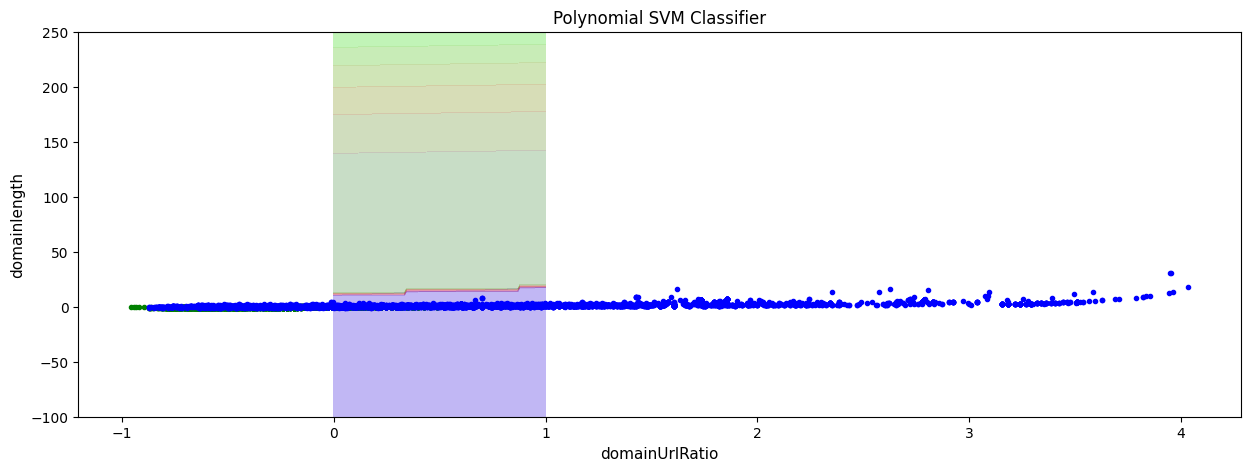

In [57]:
fig, axes = plt.subplots(figsize=(15,5), sharey=True)
plotDataset(X_train_reduced.values, y_train_num)
plotPredictions(svm_clf, [0, 1, -100, 250])
plt.title("Polynomial SVM Classifier")
plt.xlabel("domainUrlRatio", fontsize=11)
plt.ylabel("domainlength", fontsize=11)
plt.show()

In [58]:
y_val_pred = svm_clf.predict(X_val_reduced)
X_test_prep_reduced = X_test_prep[["domainUrlRatio", "domainlength"]]
y_test_pred = svm_clf.predict(X_test_prep_reduced)
y_test_num = y_test.factorize()[0]

In [59]:
f1_test = f1_score(y_test_num, y_test_pred, average='weighted')
print(f"{f1_test}")

0.8719001729698795


In [60]:
svm_poly_clf = SVC(kernel="poly", degree=3, C=40)
svm_poly_clf.fit(X_train_prep, y_train_num)
y_val_pred = svm_poly_clf.predict(X_val_prep)
y_test_pred = svm_poly_clf.predict(X_test_prep)

In [61]:

f1_test = f1_score(y_test_num, y_test_pred, average='weighted')
print(f"{f1_test}")

0.7190003741150732


### Gaussian Kernel

In [62]:
rbf_kernel_svm_clf = Pipeline([
            ("scaler", RobustScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=0.8, C=10000))
        ])

rbf_kernel_svm_clf.fit(X_train_reduced, y_train_num)

Pipeline(steps=[('scaler', RobustScaler()),
                ('svm_clf', SVC(C=10000, gamma=0.8))])

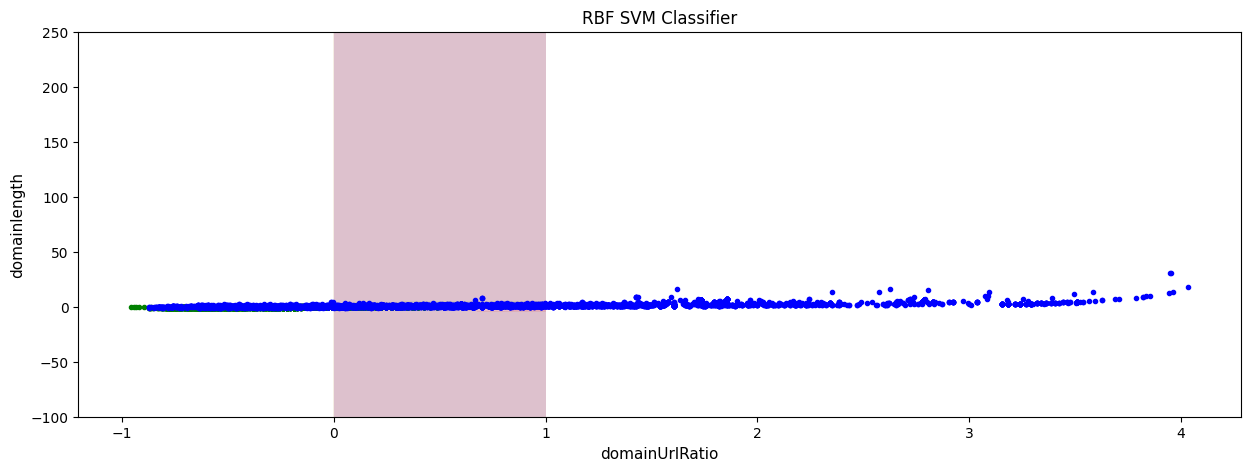

In [63]:
fig, axes = plt.subplots(figsize=(15,5), sharey=True)
plotDataset(X_train_reduced.values, y_train_num)
plotPredictions(rbf_kernel_svm_clf, [0, 1, -100, 250])
plt.title("RBF SVM Classifier")
plt.xlabel("domainUrlRatio", fontsize=11)
plt.ylabel("domainlength", fontsize=11)
plt.show()

In [64]:
y_val_pred = rbf_kernel_svm_clf.predict(X_val_reduced)
X_test_prep_reduced = X_test_prep[["domainUrlRatio", "domainlength"]]
y_test_pred = rbf_kernel_svm_clf.predict(X_test_prep_reduced)

In [65]:
f1_test = f1_score(y_test_num, y_test_pred, average='weighted')
print(f"{f1_test}")

0.8752440550081813


In [66]:
rbf_kernel_svm_clf = Pipeline([
    ("scaler", RobustScaler()),
    ("svm_clf", SVC(kernel="rbf", gamma=0.0001, C=100000))
])

rbf_kernel_svm_clf.fit(X_train_prep, y_train_num)

Pipeline(steps=[('scaler', RobustScaler()),
                ('svm_clf', SVC(C=100000, gamma=0.0001))])

In [67]:
y_val_pred = rbf_kernel_svm_clf.predict(X_val_prep)
y_test_pred = rbf_kernel_svm_clf.predict(X_test_prep)

In [69]:
f1_test = f1_score(y_test_num, y_test_pred, average='weighted')
print(f"{f1_test}")

0.8752440550081813
